In [1]:
!pip install autokeras
!pip install natsort

     |████████████████████████████████| 71kB 1.4MB/s 
     |████████████████████████████████| 26.6MB 4.0MB/s 
     |████████████████████████████████| 582.5MB 23kB/s 
     |████████████████████████████████| 61kB 19.7MB/s 
     |████████████████████████████████| 17.3MB 21.6MB/s 
     |████████████████████████████████| 5.4MB 104kB/s 
     |████████████████████████████████| 25.3MB 23.8MB/s 
     |████████████████████████████████| 51kB 21.2MB/s 
     |████████████████████████████████| 61kB 24.8MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/be/a7/37/de16bfa1fbe42e7f5821c13719179ec511633fc772871e9a32
Successfully built autokeras
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
ERROR: mxnet-cu100 1.4.1 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.16.1 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement num

In [2]:
import autokeras as ak
import numpy as np 
import pandas as pd 
from glob import glob
from skimage.io import imread
import skimage.io as sio
import os
from natsort import natsorted
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from skimage.transform import resize, rotate
import warnings; warnings.filterwarnings("ignore")

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
# train test directories
root_dir = "../input"
train_dir = root_dir + "/train/train/"
test_dir  = root_dir + "/test/test/"
csv_path  = root_dir + "/train.csv"
sub_path  = root_dir + "sample_submission.csv"

# loading images
df   = pd.read_csv(csv_path)
x    = np.array([ imread(train_dir+p)/255 for p in df.id.values])
y    = df.has_cactus.values

In [4]:
# splitting training dataset into train/validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.20,stratify=y)

In [5]:
# helper functions here
def display_images(imgs,y=None, y_pred=None):
    n_images = imgs.shape[0]
    n_gridx  = 5
    n_gridy  = n_images//n_gridx
#     n_grid   = int(np.sqrt(n_images))
    k = 1
    plt.figure(figsize=(10,6),frameon=False)
    for i in range(n_gridy):
        for j in range(n_gridx):
            plt.subplot(n_gridy, n_gridx, k)
            plt.imshow(imgs[k-1])
            plt.axis("off")
            if (y is not None) and (y_pred is not None):
                plt.title("y=%d | pred=%0.1f"%(y[k-1],y_pred[k-1]))
            elif y is not None:
                plt.title("y=%d"%y[k-1])
            k+=1
    plt.tight_layout()
    plt.show()


def getProb(model, x):
    xprocessed = model.preprocess(x)
    loader = model.data_transformer.transform_test(xprocessed)
    probs  = model.cnn.predict(loader)
    num    = np.exp(probs[:,1])
    denom  = num + np.exp(probs[:,0])
    probs  = num / denom 
    return probs


# VISUALIZING CACTUS IMAGES

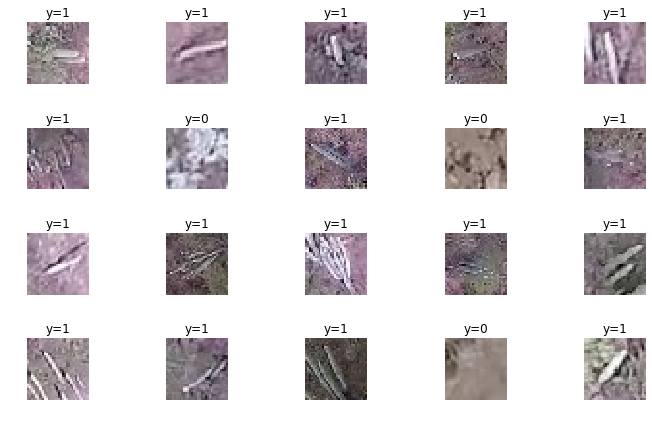

In [6]:
n_samples  = 20
idx_sample = np.random.randint(0,len(x_train),n_samples)
display_images(x_train[idx_sample], y_train[idx_sample])

# AutoKeras 

AutoKeras will automatically look for different models via a Neural Architecture search algorithm. The AutoKeras packages provides a very nice interface, much like Keras. Simply calling fit() method on the ImageClassifier object will start architecture search.

In [7]:
runFor = 5 # time in hours
model = ak.ImageClassifier(verbose=True, augment=True )
model.fit(x_train, y_train, time_limit=4*60*60)

Saving Directory: /tmp/autokeras_1JFMNS
Preprocessing the images.
Preprocessing finished.

Initializing search.
Initialization finished.


+----------------------------------------------+
|               Training model 0               |
+----------------------------------------------+
                                                                                                    
No loss decrease after 5 epochs.


Saving model.
+--------------------------------------------------------------------------+
|        Model ID        |          Loss          |      Metric Value      |
+--------------------------------------------------------------------------+
|           0            |  0.33118781745433806   |         0.962          |
+--------------------------------------------------------------------------+


+----------------------------------------------+
|               Training model 1               |
+----------------------------------------------+
                              

In [8]:
# model.final_fit(x_train, y_train, x_val, y_val, retrain=False)
y_pred = model.predict(x_train)
y_prob = getProb(model, x_train)
print("training   accuracy  = ", accuracy_score(y_train, y_pred))
print("training   recall    = ", recall_score(y_train, y_pred))
print("training   precision = ", precision_score(y_train, y_pred))
print("training   auc score = ", roc_auc_score(y_train, y_prob))
print("training   f1 score  = ", f1_score(y_train, y_pred))
y_pred = model.predict(x_val)
y_prob = getProb(model, x_val)
print("validation accuracy  = ", accuracy_score(y_val, y_pred))
print("validation recall    = ", recall_score(y_val, y_pred))
print("validation precision = ", precision_score(y_val, y_pred))
print("validation auc score = ",roc_auc_score(y_val, y_prob))
print("validation f1 score  = ", f1_score(y_val, y_pred))

training   accuracy  =  0.9984285714285714
training   recall    =  0.9983823389475688
training   precision =  0.999523673430504
training   auc score =  0.9999622753821329
training   f1 score  =  0.9989526801866134
validation accuracy  =  0.9971428571428571
validation recall    =  0.9965740388275599
validation precision =  0.9996181748759069
validation auc score =  0.999918896680912
validation f1 score  =  0.9980937857415174


# Test Prediction

In [9]:
df_test = pd.read_csv('../input/sample_submission.csv')
x_test  = np.array([ imread(test_dir+p)/255 for p in df_test.id.values])
x_test  = np.array(x_test)

# test prediction
y_prob_test = getProb(model, x_test)

df_test['has_cactus'] = y_prob_test
df_test.to_csv('cactus_net_submission.csv', index=False)